# Filter

## Imports

In [2]:
import tkinter as tk
from winsound import Beep
from time import time
from tkinter import filedialog

import numpy as np
import plotly.express as px
import plotly.io as pio
from PIL import Image as im

pio.templates.default = 'plotly_dark'

## Functions

In [3]:
def draw(image, mode='rgb'):
    if mode == 'gray':
        color_scale = ['#000000', '#FFFFFF']
        px.imshow(image, color_continuous_scale=color_scale).update_layout(height=950).show()
    elif mode == 'rgb':
        px.imshow(image).update_layout(height=950).show()

In [4]:
def gaussian_kernel(size=5, sig=1.):
    # https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy

    assert size % 2 == 1, 'Size should be an odd number.'

    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [5]:
def pixelate(img, pixel_size):
    width, height = img.size
    num_blocks_x = width // pixel_size
    num_blocks_y = height // pixel_size

    img = img.resize((num_blocks_x, num_blocks_y), resample=im.NEAREST)
    img = img.resize((width, height), resample=im.NEAREST)

    return img

In [6]:
def sliding_function(img, kernel):
    img = np.array(img)

    kernel_size = kernel.shape[1]
    pad_size = kernel_size // 2

    padded = np.pad(img, pad_size, mode='edge')
    padded_h, padded_w = padded.shape

    for h in range(padded_h-kernel_size+1):
        for w in range(padded_w-kernel_size+1):
            img[h, w] = np.sum(
                padded[h:h+kernel_size, w:w+kernel_size] * kernel)

    return im.fromarray(img)

In [7]:
def rgb_sliding(img, kernel):
    img_arr = np.array(img)
    blurred_image = np.zeros_like(img_arr)
    for idx, channel in enumerate((img_arr[:,:,0],img_arr[:,:,1],img_arr[:,:,2])):
        blurred_channel = sliding_function(channel, kernel)
        blurred_image[:,:,idx] = blurred_channel
    return im.fromarray(blurred_image)

In [8]:
def crt_effect(img,intensity=1):
    if intensity == 0:
        return img
    hsv_arr = np.array(img.convert('HSV'))
    gray = hsv_arr[:,:,2]
    img = np.array(img)
    height = gray.shape[0]

    for h in range(height)[:-intensity:intensity*2]:
        for sub_h in range(intensity):
            gray[h+sub_h, :] -= gray[h+sub_h, :]//8

    hsv_arr[:,:,0] = (hsv_arr[:,:,0] - 5) % 256
    hsv_arr[:,:,1] = (hsv_arr[:,:,1] - hsv_arr[:,:,1] // 3) % 256
    hsv_arr[:,:,2] = gray
    
    return im.fromarray(hsv_arr,'HSV').convert('RGB')

In [9]:
def invert_image(mat):
    return 255-mat

In [10]:
def dodge_blend(back, front):
    # https://pylessons.com/pencil-sketch
    with np.errstate(divide='ignore', invalid='ignore'):
        result = back*255.0 / front
        result[result=='inf'] = 255
        result = np.nan_to_num(result)
        result = np.clip(result,0,255)
    return result.astype('uint8')

In [11]:
def overlay_image(img, overlay):
    new_img = np.zeros_like(img)
    overlay = np.array(overlay)
    for i in range(3):
        channel = np.array(img)[:,:,i].astype(np.float64)
        channel*= overlay/255
        channel = channel.astype(np.uint8)
        new_img[:,:,i]=channel
        
    return im.fromarray(new_img)

In [12]:
def increase_contrast(gray_img, contrast=0):
    gray_arr = np.array(gray_img)
    
    minval = np.percentile(gray_arr, 0+contrast)
    maxval = np.percentile(gray_arr, 100-contrast)
    
    gray_arr = np.clip(gray_arr, minval, maxval)
    gray_arr = ((gray_arr - minval) / (maxval - minval)) * 255

    return im.fromarray(gray_arr.astype(np.uint8))

In [13]:
def create_shifted_sketch(img, kernel, shift_x=0, shift_y=0, contrast=0):

    hsv_arr = np.array(img.convert('HSV'))
    gray = hsv_arr[:,:,2]

    blurred_gray = sliding_function(gray, kernel)
    sketch = dodge_blend(gray, blurred_gray)

    sketch = increase_contrast(sketch, contrast) if not contrast == 0 else sketch

    shifted_sketch = np.roll(sketch, shift_x, 1)
    shifted_sketch = np.roll(shifted_sketch, shift_y, 0)
    
    return im.fromarray(shifted_sketch)

In [14]:
def purpleise(img, threshold=40):
    if threshold == 0:
        return img
    
    hsv_arr = np.array(img.convert('HSV'))
    img = np.array(img)

    h = hsv_arr[:, :, 0]
    s = hsv_arr[:, :, 1]
    v = hsv_arr[:, :, 2]
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]

    threshold_values = v<threshold
    blurred_mask = np.array(sliding_function(
        threshold_values.astype(np.float64), gaussian_kernel(25, 3)))

    r += (blurred_mask*150).astype(np.uint8)
    b += (blurred_mask*150).astype(np.uint8)

    img[:, :, 0], img[:, :, 1], img[:, :, 2] = r, g, b
    
    return im.fromarray(img)

In [15]:
def chroma_shift(img, rgb_shift:(5,0,-5)):
    img = np.array(img)
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]

    r_shifted = np.roll(r, rgb_shift[0], axis=(0, 1))
    g_shifted = np.roll(g, rgb_shift[1], axis=(0, 1))
    b_shifted = np.roll(b, rgb_shift[2], axis=(0, 1))

    img[:, :, 0], img[:, :, 1], img[:, :, 2] = r_shifted, g_shifted, b_shifted

    return im.fromarray(img)

In [16]:
def radial_chromatic_aberration(img, strength=0.02):
    if strength == 0:
        return
    width = img.width
    height = img.height

    data = np.array(img)
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    distance = np.sqrt((x - width / 2) ** 2 + (y - height / 2) ** 2)

    red_channel = np.clip((x - distance * strength).astype(int), 0, width - 1)
    blue_channel = np.clip((x + distance * strength).astype(int), 0, width - 1)
    # red_channel = np.maximum(0, np.minimum((x - distance * strength).astype(int), width - 1)).astype(int)
    # blue_channel = np.maximum(0, np.minimum((x + distance * strength).astype(int), width - 1)).astype(int)
    green_channel = y.astype(int)

    data[:, :, 0] = data[green_channel, red_channel, 0]
    data[:, :, 1] = data[:, :, 1]
    data[:, :, 2] = data[green_channel, blue_channel, 2]

    result_image = im.fromarray(data.astype(np.uint8))

    return result_image

# Image Open

In [17]:
root = tk.Tk()
root.lift()
root.attributes("-topmost", True)
root.withdraw()

file_path = filedialog.askopenfilename()

src = im.open(file_path)

Dowscaling code just in case

In [18]:
DOWNSCALE_FACTOR = 1
img = src.resize((src.size[0]//DOWNSCALE_FACTOR, src.size[1]//DOWNSCALE_FACTOR),im.Resampling.BOX)
hsv = img.convert('HSV')

# Outputs

## Effect 1: Blurred CRT Effect

In [ ]:
# kernel = np.array([[1,2,1], [2,-4,2], [1,2,1]])
# kernel = np.array([[1,2,1], [2,4,2], [1,2,1]])

kernel = gaussian_kernel(25, 5)


blur = rgb_sliding(img, kernel)

crt = crt_effect(blur, intensity=4)


display(crt)
# draw(result,'rgb')
# result.show()

## Effect 2: Sketch Effect

In [ ]:
kernel = gaussian_kernel(15, 5)

sketch = create_shifted_sketch(img, kernel, contrast=2)

display(sketch)

### Shifted Overlay

In [ ]:
kernel = gaussian_kernel(25, 5)

shifted_sketch = create_shifted_sketch(img,kernel,100,100, contrast=2)

ghost_image = overlay_image(img, shifted_sketch)
ghost_image

## Effect 3: Purpleise

In [31]:
purpleise(img, 38)

## Effect 4: Chromatic Abbretion

In [33]:
radial_chromatic_aberration(img, 0.018)

# FINAL RESULT

In [117]:
root = tk.Tk()
root.lift()
root.attributes("-topmost", True)
root.withdraw()

file_path = filedialog.askopenfilename()

src = im.open(file_path)

DOWNSCALE_FACTOR = 1
img = src.resize((src.size[0]//DOWNSCALE_FACTOR, src.size[1]//DOWNSCALE_FACTOR),im.Resampling.BOX)
hsv = img.convert('HSV')

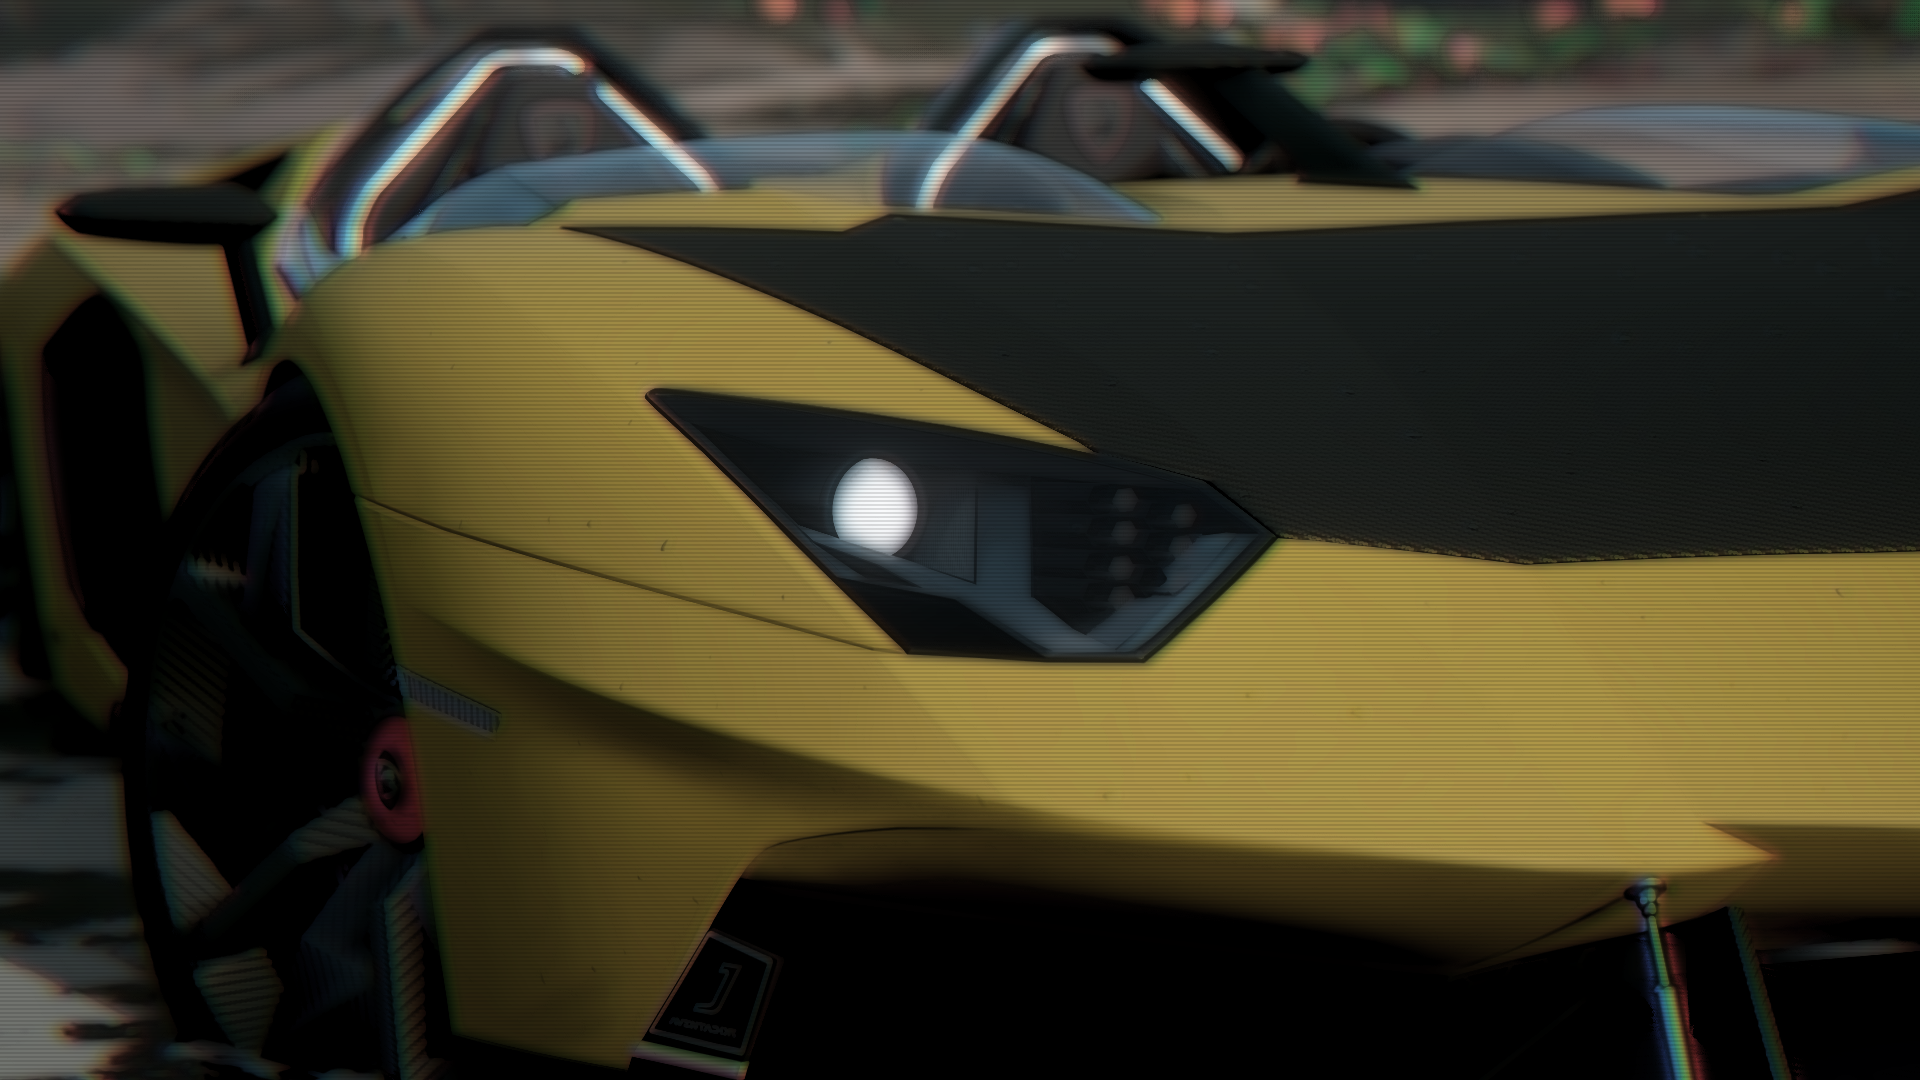

### Elapsed Time: 51.5 seconds ###


In [120]:
s = time()
kernel = gaussian_kernel(25, 5)

blurred_image = rgb_sliding(img, kernel)
aberration = radial_chromatic_aberration(blurred_image, 0.018)

purple = purpleise(aberration, 38)

dodge_kernel = gaussian_kernel(15, 5)

shifted_sketch = create_shifted_sketch(img, dodge_kernel, contrast=2)
overlay = overlay_image(purple, shifted_sketch)

crt = crt_effect(overlay, intensity=4)

result = crt
display(result)

e = time()
Beep(2093, 250)
print(f'### Elapsed Time: {e-s:.1f} seconds ###')

# Export

In [121]:
f = filedialog.asksaveasfile(mode='w', defaultextension=".png",filetypes=[(".png","*.png"),(".jpg","*.jpg")])
if f:
    result.save(f.name)
    f.close()